# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Loading the data

In [2]:
DATASET_PATH = "./OUTPUTS_data/ALL_merged.csv"
# DATASET_PATH = "./Davidson-Original/train_ORIGINAL.csv"
LANGUAGE = "ALL"
TEST_DATASET_PATH = "./Davidson-Original/test.csv"

df = pd.read_csv(DATASET_PATH)

In [3]:
df.columns = ['tweet', 'class']
df.columns

Index(['tweet', 'class'], dtype='object')

In [4]:
df["class"].value_counts()

class
1    17285
0     8861
2     3753
Name: count, dtype: int64

In [5]:
test_dataset = pd.read_csv(TEST_DATASET_PATH)

In [6]:
# Change column names
test_dataset.columns = ['tweet', 'class']

print(test_dataset['class'].value_counts())
test_dataset.head()

class
1    1905
2     410
0     164
Name: count, dtype: int64


,tweet,class
0,934 8616\ni got a missed call from yo bitch,1
1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...,1
2,RT @eanahS__: @1inkkofrosess lol my credit ain...,2
3,RT @Maxin_Betha Wipe the cum out of them faggo...,1
4,Niggas cheat on they bitch and don't expect no...,1


In [7]:
X_test = test_dataset['tweet']
y_test = test_dataset['class'].astype(int)

X_train = df['tweet']
y_train = df['class'].astype(int)

# Add isTest column to the training dataset
df['isTest'] = 0

# Add isTest column to the test dataset
test_dataset['isTest'] = 1

# Concatenate the two datasets
merged_df = pd.concat([df, test_dataset], ignore_index=True)

merged_df.tail(5)

,tweet,class,isTest
32373,"RT @BreadTruckkBri: ""@VoiceOfDStreetz: &#8220;...",1,1
32374,Selling ex lax brownies in front of Meijer to ...,2,1
32375,&#8220;@kaitlinfryer: Big oleeeee middle finge...,1,1
32376,&#8220;@iamkrause: All I see in every #IfTheyG...,2,1
32377,"""@royalswagg_: using y=mx+b to find the slope ...",1,1


In [8]:
# Separate X and y
X_merged = merged_df['tweet']
y_merged = merged_df['class']
isTest_merged = merged_df['isTest']

# Display a sample of the merged dataset
merged_df.head()

,tweet,class,isTest
0,"Bitches ah have a baby &amp; be like ""don't cl...",1,0
1,"""@ayyee_ceee_: One mans trash &#128686; is ano...",2,0
2,RT @IKeepitRealer: ChrisBrown a bitch 4 hittin...,1,0
3,"People comment on my fb statuses like ""How was...",1,0
4,RT @TreLeKidd: Yo bitch is Gucci Mane RT @Jaba...,1,0


In [9]:
merged_df.tail()

,tweet,class,isTest
32373,"RT @BreadTruckkBri: ""@VoiceOfDStreetz: &#8220;...",1,1
32374,Selling ex lax brownies in front of Meijer to ...,2,1
32375,&#8220;@kaitlinfryer: Big oleeeee middle finge...,1,1
32376,&#8220;@iamkrause: All I see in every #IfTheyG...,2,1
32377,"""@royalswagg_: using y=mx+b to find the slope ...",1,1


### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


<Axes: >

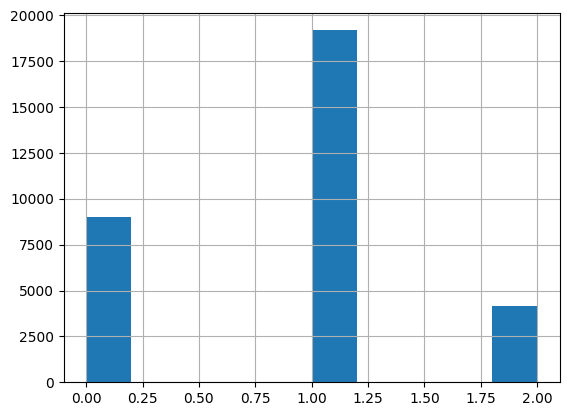

In [10]:
y_merged.hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [11]:
tweets=X_merged

## Feature generation

In [12]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text) #URLHERE
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text) #MENTIONHERE
    return parsed_text

def tokenize(tweet):
    # Split the tweet into individual words, remove non-alphabetic characters, and convert to lowercase
    tweet = " ".join(re.findall("[a-zA-Z]+", tweet.lower()))
    # Apply stemming to each word
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.findall("[a-zA-Z]+", tweet.lower()))
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [15]:
#Construct tfidf matrix and get relevant scores
# tfidf_test = vectorizer.transform(X_test).toarray()


# vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
# idf_vals = vectorizer.idf_
# idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [16]:
print(len(tfidf), len(tfidf[0]), len(tfidf[1]))
# len(tfidf_test), len(tfidf_test[0]), len(tfidf_test[1])

32378 10000 10000


In [17]:
print(len(vectorizer.get_feature_names_out()))
print(len(idf_vals))

10000
10000


In [18]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [19]:
# X_test

In [20]:
#Get POS tags for tweets and save as a string
# tweet_tags_for_test_set = []
# for t in X_test:
#     tokens = basic_tokenize(preprocess(t))
#     tags = nltk.pos_tag(tokens)
#     tag_list = [x[1] for x in tags]
#     tag_str = " ".join(tag_list)
#     tweet_tags_for_test_set.append(tag_str)

In [21]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [22]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [23]:
print(len(pos_vocab))
pos_vocab

4666


{'CC': 0,
 'CC CC': 1,
 'CC CD': 2,
 'CC CD IN': 3,
 'CC CD NN': 4,
 'CC CD NNS': 5,
 'CC DT': 6,
 'CC DT CC': 7,
 'CC DT IN': 8,
 'CC DT JJ': 9,
 'CC DT NN': 10,
 'CC DT NNS': 11,
 'CC DT PRP': 12,
 'CC DT RB': 13,
 'CC DT VBD': 14,
 'CC DT VBP': 15,
 'CC DT VBZ': 16,
 'CC EX': 17,
 'CC EX VBP': 18,
 'CC EX VBZ': 19,
 'CC IN': 20,
 'CC IN DT': 21,
 'CC IN IN': 22,
 'CC IN JJ': 23,
 'CC IN JJS': 24,
 'CC IN NN': 25,
 'CC IN NNS': 26,
 'CC IN PRP': 27,
 'CC IN RB': 28,
 'CC IN VBP': 29,
 'CC IN VBZ': 30,
 'CC JJ': 31,
 'CC JJ CC': 32,
 'CC JJ DT': 33,
 'CC JJ IN': 34,
 'CC JJ JJ': 35,
 'CC JJ MD': 36,
 'CC JJ NN': 37,
 'CC JJ NNS': 38,
 'CC JJ PRP': 39,
 'CC JJ RB': 40,
 'CC JJ TO': 41,
 'CC JJ VB': 42,
 'CC JJ VBD': 43,
 'CC JJ VBN': 44,
 'CC JJ VBP': 45,
 'CC JJ VBZ': 46,
 'CC JJR': 47,
 'CC JJS': 48,
 'CC MD': 49,
 'CC MD RB': 50,
 'CC MD VB': 51,
 'CC NN': 52,
 'CC NN CC': 53,
 'CC NN DT': 54,
 'CC NN IN': 55,
 'CC NN JJ': 56,
 'CC NN MD': 57,
 'CC NN NN': 58,
 'CC NN NNS': 59,
 'CC

In [24]:
#Construct POS TF matrix and get vocab dict
# pos_test = pos_vectorizer.transform(pd.Series(X_test)).toarray()
# pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [25]:
print(len(pos), len(pos[0]), len(pos[1]))
# len(pos_test), len(pos_test[0]), len(pos_test[1])

32378 4666 4666


In [26]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [27]:
# Example text
text_string = "Check out this cool website: https://www.example.com #Python #MachineLearning @user1 @user2"

# Count the number of URLs, mentions, and hashtags
url_count, mention_count, hashtag_count = count_twitter_objs(text_string)
print(preprocess(text_string))
# preprocess
# Print the counts
print("URL count:", url_count)
print("Mention count:", mention_count)
print("Hashtag count:", hashtag_count)

Check out this cool website: URLHERE #Python #MachineLearning MENTIONHERE MENTIONHERE
URL count: 1
Mention count: 2
Hashtag count: 2


In [28]:
tweetAA = "This is a sample tweet! It contains hashtags like #Python and mentions like @user. Also, it has some URLs: https://example.com"
print(other_features(tweetAA))

[8.7, 68.1, 28, 1.4, 120, 126, 20, 20, 19, 0.0, 0.227, 0.773, 0.6476, 1, 1, 1, 0]


In [29]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [30]:
feats = get_feature_array(tweets)

In [31]:
# feats_test = get_feature_array(X_test)

In [32]:
print(len(feats), len(feats[0]), len(feats[1]))
# len(feats_test), len(feats_test[0]), len(feats_test[1])

32378 17 17


In [33]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
# M_test = np.concatenate([tfidf_test,pos_test,feats_test],axis=1)



In [34]:
print(M.shape)
# M_test.shape


(32378, 14683)


In [35]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [36]:
len(feature_names)

14683

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [37]:
X = pd.DataFrame(M)
y = y_merged

# X_test = pd.DataFrame(M_test)
# y_test = y_test

In [38]:
# Make X a dtaframe with the feature_name as columns
X.columns = feature_names

# Put isTest column in the X dataframe
X['isTest'] = isTest_merged

print(X.shape)
print(y.shape)

X.head()

(32378, 14684)
(32378,)


,aa,aap,ab,abil,abl,abo,abort,abov,absolut,abt,...,num_unique_words,vader neg,vader pos,vader neu,vader compound,num_hashtags,num_mentions,num_urls,is_retweet,isTest
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,0.298,0.207,0.496,-0.6486,2.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.000,0.196,0.804,0.2960,2.0,1.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.304,0.034,0.661,-0.9042,2.0,1.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.295,0.185,0.519,-0.6072,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,0.352,0.000,0.648,-0.8225,2.0,2.0,1.0,0.0,0


In [39]:
X.tail()

,aa,aap,ab,abil,abl,abo,abort,abov,absolut,abt,...,num_unique_words,vader neg,vader pos,vader neu,vader compound,num_hashtags,num_mentions,num_urls,is_retweet,isTest
32373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,0.00,0.167,0.833,0.4215,2.0,3.0,0.0,0.0,1
32374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.00,0.000,1.000,0.0000,1.0,0.0,0.0,0.0,1
32375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.00,0.000,1.000,0.0000,2.0,1.0,0.0,0.0,1
32376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,0.00,0.143,0.857,0.3612,3.0,1.0,1.0,0.0,1
32377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.28,0.000,0.720,-0.5423,0.0,1.0,0.0,0.0,1


In [40]:
# Splitting the data based on the 'isTest' column
X_train = X[X['isTest'] == 0].drop(columns=['isTest'])
y_train = y_merged[isTest_merged == 0]
X_test = X[X['isTest'] == 1].drop(columns=['isTest'])
y_test = y_merged[isTest_merged == 1]


# X_train = X[isTest_merged == 0]
# y_train = y_merged[isTest_merged == 0]
# X_test = X[isTest_merged == 1]
# y_test = y_merged[isTest_merged == 1]

# print("Train set shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print(y_train.value_counts())
# print("Test set shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
# print(y_test.value_counts())

In [41]:
y_train.head()

0    1
1    2
2    1
3    1
4    1
Name: class, dtype: int64

In [42]:
y_test.tail()

32373    1
32374    2
32375    1
32376    2
32377    1
Name: class, dtype: int64

In [43]:
print(y_train.value_counts())
print(y_test.value_counts())

class
1    17285
0     8861
2     3753
Name: count, dtype: int64
class
1    1905
2     410
0     164
Name: count, dtype: int64


In [44]:
# # EXAMPLE

# import numpy as np
# import pandas as pd

# # Generating sample data
# np.random.seed(0)
# data = {
#     'feature': np.random.rand(100),
#     'label': np.random.randint(0, 2, size=100),  # Random labels (0 or 1)
#     'isTest': np.random.randint(0, 2, size=100)  # Random isTest values (0 or 1)
# }

# # Creating a DataFrame
# df = pd.DataFrame(data)

# # Display the first few rows of the DataFrame
# print("Original DataFrame:")
# print(df.head())

# X = df['feature']
# y = df['label']

# # Add some columns to X
# X = pd.concat([X, pd.DataFrame(np.random.rand(100, 2), columns=['col1', 'col2'])], axis=1)

# # Display X after adding columns
# print("X with additional columns:")
# print(X.head())

# # Splitting the data based on the 'isTest' column
# X_train = X[df['isTest'] == 0]
# y_train = y[df['isTest'] == 0]
# X_test = X[df['isTest'] == 1]
# y_test = y[df['isTest'] == 1]

# # Sample data after splitting
# print("\nTrain data:")
# print(X_train.head())
# print("\nTest data:")
# print(X_test.head())

In [45]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [46]:
# PENALTY CHANGED to => L2
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l2", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [47]:
param_grid = [{}] # Optionally add parameters here

In [48]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42, shuffle=True).split(X_train, y_train), 
                           verbose=2)

In [49]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .................................................... total time= 2.2min


c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .................................................... total time= 2.2min


c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .................................................... total time= 2.1min


c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .................................................... total time= 2.3min


c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .................................................... total time= 2.4min


c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Owner\anaconda3\envs\DCL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [50]:
y_preds = model.predict(X_test)

## Evaluating the results

In [51]:
report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [52]:
print(report)

              precision    recall  f1-score   support

           0       0.32      0.59      0.41       164
           1       0.96      0.87      0.91      1905
           2       0.81      0.90      0.85       410

    accuracy                           0.85      2479
   macro avg       0.70      0.78      0.72      2479
weighted avg       0.89      0.85      0.87      2479



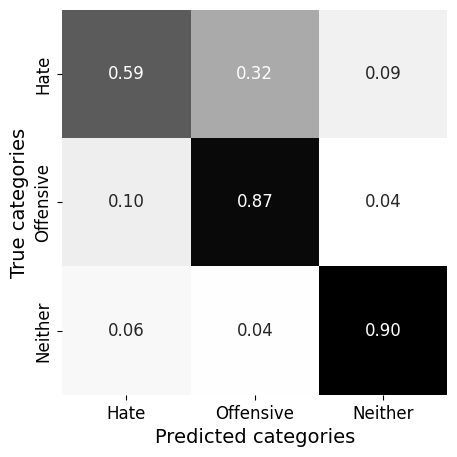

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
plt.savefig('./OUTPUTS-conf-matrix/'+LANGUAGE+'-confusion_matrix.png', dpi=300)  # Save the plot as PNG with 300 DPI resolution
# plt.savefig('./OUTPUTS-conf-matrix/BASELINE-confusion_matrix.png', dpi=300)  

<Axes: >

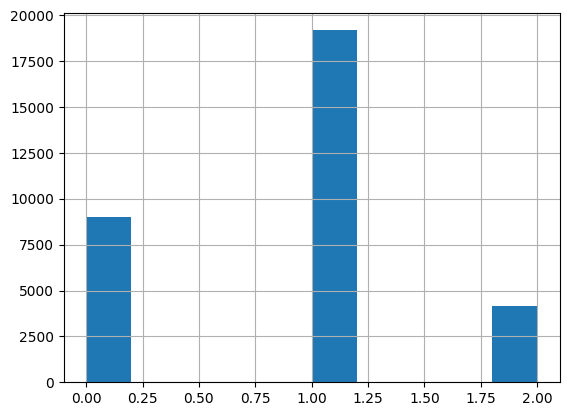

In [54]:
#True distribution
y.hist()

<Axes: >

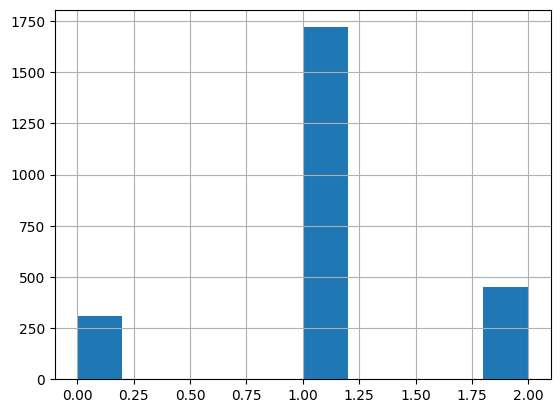

In [55]:
pd.Series(y_preds).hist()